1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from joblib import dump

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]
file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 23-24.csv"

# Load the data
df = pd.read_csv(file_path, usecols=usecols)

# Add a simple MatchIndex and assign rounds (10 matches per round)
df['MatchIndex'] = df.index + 1
df['Round']      = np.ceil(df['MatchIndex'] / 10).astype(int)

# Parse the kickoff time into buckets (Morning, Afternoon, Evening)
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins   = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

# Quick sanity check
print("Loaded shape:", df.shape)

Loaded shape: (380, 27)


3. Leakage-Free Feature Engineering

In [3]:
# 3.1 Targets
df['Outcome']  = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5']  = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# 3.2 Implied probabilities from odds
for side in ['H','D','A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H','ImpProb_D','ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5','ImpUnder2.5']] = (
    df[['ImpOver2.5','ImpUnder2.5']]
      .div(df[['ImpOver2.5','ImpUnder2.5']].sum(axis=1), axis=0)
)

# 3.3 Odds spread
df['OddsSpread'] = df['B365H'] - df['B365A']

# 3.4 Rolling 3-match form
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# 3.5 Win/Loss streaks
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: 
          s.eq(1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(1)).cumsum()).cumsum()
      )
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: 
          s.eq(-1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(-1)).cumsum()).cumsum()
      )
)

# 3.6 Interaction
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.7 Referee home-bias
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins','RefMatches'], inplace=True)

# 3.8 Head-to-head last result
df['PairKey'] = df.apply(
    lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1
)
h2h = {}
def prev_h2h(row):
    key = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

# 3.9 Rolling averages of match stats
home_stats = ['HS','HST','HF','HC','HY','HR']
away_stats = ['AS','AST','AF','AC','AY','AR']
for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )
for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# 3.10 Previous-round table positions
df['HomePts'] = np.where(df['FTR']=='H', 3, np.where(df['FTR']=='D', 1, 0))
df['AwayPts'] = np.where(df['FTR']=='A', 3, np.where(df['FTR']=='D', 1, 0))

pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'],    df['Round']]),
    'Pts':   np.concatenate([df['HomePts'],   df['AwayPts']])
})
round_pts = (
    pts
    .groupby(['Team','Round'], as_index=False)['Pts']
    .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()
round_pts['Pos']    = (
    round_pts
    .groupby('Round')['CumPts']
    .rank(method='min', ascending=False)
)
prev = round_pts[['Team','Round','Pos']].copy()
prev.rename(columns={'Round':'PrevRound','Pos':'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

df = df.merge(
    prev, left_on=['HomeTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

df = df.merge(
    prev, left_on=['AwayTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

# Fill any remaining NaNs in numeric features
num_feats = [
    'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5',
    'OddsSpread','Spread×Form','RefBias','H2H_Last',
    'HomePosPrev','AwayPosPrev'
] + [f'Home_{s}_3' for s in home_stats] + [f'Away_{s}_3' for s in away_stats]
df[num_feats] = df[num_feats].fillna(0)

4. Pipeline Specification & Hyperparameter Distributions

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint

import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model

# 4.1) Safety: feature lists (recreate if earlier cell wasn't run)
if 'cat_feats' not in globals() or 'num_feats' not in globals():
    cat_feats = [c for c in ['HomeTeam','AwayTeam','Referee','TimeOfDay'] if c in df.columns]
    base_num = [
        'ImpProb_H','ImpProb_D','ImpProb_A',
        'ImpOver2.5','ImpUnder2.5','OddsSpread','Spread×Form',
        'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
        'RefBias','H2H_Last','HomePosPrev','AwayPosPrev',
        'Home_HS_3','Home_HST_3','Home_HF_3','Home_HC_3','Home_HY_3','Home_HR_3',
        'Away_AS_3','Away_AST_3','Away_AF_3','Away_AC_3','Away_AY_3','Away_AR_3'
    ]
    num_feats = [c for c in base_num if c in df.columns]

# 4.2) RF preprocessing (no z-score; OHE dense)
rf_cat = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', min_frequency=2, sparse_output=False))
])
rf_num = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    # optional: ('mm', MinMaxScaler())  # ha nagyon eltérő skálák vannak
])
rf_pre = ColumnTransformer(
    transformers=[('cat', rf_cat, cat_feats), ('num', rf_num, num_feats)],
    sparse_threshold=0.0
)

# 4.3) MLP preprocessing (OHE sparse → később .toarray(), numerics StandardScaler)
mlp_cat = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', min_frequency=2, sparse_output=True))
])
mlp_num = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value=0)),
    ('std', StandardScaler())
])
mlp_pre = ColumnTransformer(
    transformers=[('cat', mlp_cat, cat_feats), ('num', mlp_num, num_feats)],
    sparse_threshold=1.0
)

# 4.4) RF model + randomized search space (time-series CV)
def make_rf():
    return Pipeline([
        ('prep', rf_pre),
        ('clf', RandomForestClassifier(
            n_estimators=900,
            max_depth=None,
            min_samples_leaf=10,
            max_features='sqrt',
            class_weight='balanced_subsample',
            n_jobs=-1,
            random_state=42
        ))
    ])

tscv = TimeSeriesSplit(n_splits=3)
rf_space = {
    'clf__n_estimators': randint(700, 1200),
    'clf__max_depth': [None, 12, 14, 16, 18, 20],
    'clf__min_samples_leaf': randint(5, 20),
    'clf__max_features': ['sqrt', 0.5, 0.6, 0.7, 0.8]
}
def make_rf_search():
    return RandomizedSearchCV(
        make_rf(), rf_space, n_iter=25, cv=tscv,
        scoring='accuracy', n_jobs=-1, random_state=42, verbose=0
    )

# 4.5) Keras MLP (BN + L2 + Dropout; stabil kis háló tabulárisra)
def make_mlp(input_dim: int, hidden1: int = 96, hidden2: int = 48,
             dropout: float = 0.35, l2_reg: float = 1e-3, lr: float = 5e-4) -> Model:
    tf.keras.utils.set_random_seed(42)
    inp = layers.Input(shape=(input_dim,), name='x')
    x = layers.Dense(hidden1, use_bias=False, kernel_regularizer=regularizers.l2(l2_reg))(inp)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x); x = layers.Dropout(dropout)(x)
    x = layers.Dense(hidden2, use_bias=False, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x); x = layers.Dropout(dropout)(x)
    out = layers.Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

EARLY_STOP = tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_accuracy', restore_best_weights=True)
REDUCE_LR  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-5, verbose=0)
MAX_EPOCHS = 80

# 4.6) Utilities
label2idx = {-1: 0, 0: 1, 1: 2}
idx2label = {v: k for k, v in label2idx.items()}

def compute_class_weights(y_int: np.ndarray, draw_boost: float = 1.2) -> dict:
    if y_int.size == 0: return {0:1.0,1:1.0,2:1.0}
    vals, counts = np.unique(y_int, return_counts=True)
    total = counts.sum()
    w = {int(v): float(total / (len(vals) * c)) for v, c in zip(vals, counts)}
    for k in [0,1,2]: w.setdefault(k, 1.0)
    w[1] = w.get(1, 1.0) * draw_boost  # boost Draw slightly
    return w

def reorder_proba_cols(P: np.ndarray, classes_: np.ndarray, target_order=[-1,0,1]) -> np.ndarray:
    order = {c:i for i,c in enumerate(classes_)}
    idx = [order[c] for c in target_order]
    return P[:, idx]


5. Round-by-Round Training & Prediction with Tuning

In [ ]:
from scipy import sparse
from sklearn.metrics import accuracy_score

# 5.1) Result containers
preds, actuals, rounds, match_indices = [], [], [], []

# 5.2) Warm-up (first 5 rounds): fit preprocessors once and quick warm start for MLP
WARMUP_ROUNDS  = 5
WARMUP_MATCHES = WARMUP_ROUNDS * 10

warm_mask_all = df.index < WARMUP_MATCHES
val_mask_warm = (df['Round'] == WARMUP_ROUNDS) & warm_mask_all
if val_mask_warm.sum() >= 10:
    train_mask_warm = warm_mask_all & (~val_mask_warm)
else:
    warm_sorted = df.loc[warm_mask_all].sort_values(['Round','MatchIndex']).index
    split = int(len(warm_sorted) * 0.9)
    val_mask_warm = df.index.isin(warm_sorted[split:])
    train_mask_warm = df.index.isin(warm_sorted[:split])

# Fit MLP preprocessor on warm-train (RF külön úgyis a saját pipeline-jában tanul)
X_tr_w = mlp_pre.fit_transform(df.loc[train_mask_warm, cat_feats + num_feats])
X_va_w = mlp_pre.transform(df.loc[val_mask_warm,  cat_feats + num_feats])
X_tr_w = X_tr_w.toarray() if sparse.issparse(X_tr_w) else np.asarray(X_tr_w)
X_va_w = X_va_w.toarray() if sparse.issparse(X_va_w) else np.asarray(X_va_w)
y_tr_w = df.loc[train_mask_warm, 'Outcome'].map(label2idx).to_numpy()
y_va_w = df.loc[val_mask_warm,  'Outcome'].map(label2idx).to_numpy()

mlp_w = make_mlp(input_dim=X_tr_w.shape[1])
cw_w  = compute_class_weights(y_tr_w, draw_boost=1.2)
_ = mlp_w.fit(
    X_tr_w, y_tr_w, validation_data=(X_va_w, y_va_w),
    epochs=MAX_EPOCHS, batch_size=64, verbose=0,
    class_weight=cw_w, callbacks=[EARLY_STOP, REDUCE_LR]
)

# 5.3) Predict from round 6 onward (exactly 10 matches per round)
max_round = int(df['Round'].max())
best_model = None  # keep last round's MLP for consistency (optional)

for r in range(WARMUP_ROUNDS + 1, max_round + 1):
    train_mask = df['Round'] < r
    test_mask  = df['Round'] == r

    # test slice (exactly 10)
    round_df = df.loc[test_mask, :].sort_values(['Round','MatchIndex'])
    if len(round_df) > 10:
        round_df = round_df.head(10)
        test_mask = df.index.isin(round_df.index)
    if len(round_df) < 10:
        print(f"Round {r}: only {len(round_df)} matches available → skipped.")
        continue

    # validation = last full round r-1 (or last 10% fallback)
    val_mask = (df['Round'] == (r - 1)) & train_mask
    if val_mask.sum() < 10:
        tr_sorted = df.loc[train_mask].sort_values(['Round','MatchIndex']).index
        split = int(len(tr_sorted) * 0.9)
        val_mask = df.index.isin(tr_sorted[split:])
        train_mask = df.index.isin(tr_sorted[:split])
    else:
        train_mask = train_mask & (~val_mask)

    # --- RF: fit search on train (its pipeline contains its own preprocessor)
    X_train_rf = df.loc[train_mask, cat_feats + num_feats]
    y_train    = df.loc[train_mask, 'Outcome']
    X_val_rf   = df.loc[val_mask,  cat_feats + num_feats]
    X_test_rf  = df.loc[test_mask, cat_feats + num_feats]

    rf_rs = make_rf_search()
    rf_rs.fit(X_train_rf, y_train)
    rf = rf_rs.best_estimator_

    # RF probabilities (reordered to [-1,0,1])
    P_rf_val  = reorder_proba_cols(rf.predict_proba(X_val_rf),  rf.named_steps['clf'].classes_, [-1,0,1])
    P_rf_test = reorder_proba_cols(rf.predict_proba(X_test_rf), rf.named_steps['clf'].classes_, [-1,0,1])

    # --- MLP: fit preprocessor on train only, then train Keras
    X_train_mlp = mlp_pre.fit_transform(df.loc[train_mask, cat_feats + num_feats])
    X_val_mlp   = mlp_pre.transform(df.loc[val_mask,  cat_feats + num_feats])
    X_test_mlp  = mlp_pre.transform(df.loc[test_mask, cat_feats + num_feats])

    # densify
    X_train_mlp = X_train_mlp.toarray() if sparse.issparse(X_train_mlp) else np.asarray(X_train_mlp)
    X_val_mlp   = X_val_mlp.toarray()   if sparse.issparse(X_val_mlp)   else np.asarray(X_val_mlp)
    X_test_mlp  = X_test_mlp.toarray()  if sparse.issparse(X_test_mlp)  else np.asarray(X_test_mlp)

    y_train_mlp = df.loc[train_mask, 'Outcome'].map(label2idx).to_numpy()
    y_val_mlp   = df.loc[val_mask,  'Outcome'].map(label2idx).to_numpy()
    y_test      = df.loc[test_mask, 'Outcome'].to_numpy()  # original labels for reporting

    mlp = make_mlp(input_dim=X_train_mlp.shape[1])
    cw  = compute_class_weights(y_train_mlp, draw_boost=1.2)
    _ = mlp.fit(
        X_train_mlp, y_train_mlp,
        validation_data=(X_val_mlp, y_val_mlp),
        epochs=MAX_EPOCHS, batch_size=64, verbose=0,
        class_weight=cw, callbacks=[EARLY_STOP, REDUCE_LR]
    )
    best_model = mlp

    # MLP probabilities in class order [0,1,2] → map to [-1,0,1]
    P_mlp_val  = mlp.predict(X_val_mlp, verbose=0)
    P_mlp_test = mlp.predict(X_test_mlp, verbose=0)
    # map columns from indices [0,1,2] to labels [-1,0,1] via label2idx inverse
    # target order [-1,0,1] corresponds to idx [0,1,2] → we just reorder to [0,1,2]→[?, ?, ?]
    # Here: idx 0→-1, 1→0, 2→1  ⇒ want columns in order [-1,0,1] == [0,1,2] mapped back by idx2label
    # Therefore no column reordering needed; only the final argmax → map with idx2label.
    # For consistency with RF, we build a matrix aligned to [-1,0,1]:
    P_mlp_val_aligned  = P_mlp_val[:, [0,1,2]]
    P_mlp_test_aligned = P_mlp_test[:, [0,1,2]]

    # --- Alpha selection on validation (accuracy)
    alphas = np.linspace(0.0, 1.0, 21)  # 0.05 steps
    best_acc, best_alpha = -1.0, 0.5
    for a in alphas:
        P_blend_val = a*P_rf_val + (1-a)*P_mlp_val_aligned
        y_pred_val  = np.array([-1,0,1])[P_blend_val.argmax(axis=1)]
        acc_val     = accuracy_score(df.loc[val_mask, 'Outcome'].to_numpy(), y_pred_val)
        if acc_val > best_acc:
            best_acc, best_alpha = acc_val, a

    # --- Predict test with chosen alpha
    P_blend_test = best_alpha*P_rf_test + (1-best_alpha)*P_mlp_test_aligned
    y_pred_test  = np.array([-1,0,1])[P_blend_test.argmax(axis=1)]

    # Collect
    preds.extend(y_pred_test.tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_pred_test))            # always 10
    match_indices.extend(round_df['MatchIndex'].tolist())

    acc = accuracy_score(y_test, y_pred_test)
    print(f"Round {r}: 10 matches | accuracy = {acc:.3f} | alpha={best_alpha:.2f} | "
          f"RF best: {rf_rs.best_params_}")

print(f"Predicted rounds {WARMUP_ROUNDS + 1}–{max_round} (10 matches each)")

# 5.4) Expose final trained models from last round (optional)
final_mlp = best_model
final_rf  = rf
last_train_round = max_round - 1


Round 6: 10 matches | accuracy = 0.400 | alpha=0.70 | RF best: {'clf__max_depth': 14, 'clf__max_features': 0.8, 'clf__min_samples_leaf': 6, 'clf__n_estimators': 1043}
Round 7: 10 matches | accuracy = 0.700 | alpha=0.40 | RF best: {'clf__max_depth': 18, 'clf__max_features': 0.8, 'clf__min_samples_leaf': 11, 'clf__n_estimators': 821}
Round 8: 10 matches | accuracy = 0.400 | alpha=0.35 | RF best: {'clf__max_depth': 14, 'clf__max_features': 0.8, 'clf__min_samples_leaf': 6, 'clf__n_estimators': 1043}
Round 9: 10 matches | accuracy = 0.700 | alpha=0.55 | RF best: {'clf__max_depth': 16, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 7, 'clf__n_estimators': 1184}
Round 10: 10 matches | accuracy = 0.600 | alpha=0.30 | RF best: {'clf__max_depth': 14, 'clf__max_features': 0.8, 'clf__min_samples_leaf': 6, 'clf__n_estimators': 1043}
Round 11: 10 matches | accuracy = 0.300 | alpha=0.40 | RF best: {'clf__max_depth': 14, 'clf__max_features': 0.8, 'clf__min_samples_leaf': 6, 'clf__n_estimators':

6. Assemble, Save Results & Final Model

In [ ]:
# 6.1 Assemble DataFrame of predictions
df_idx = df.set_index('MatchIndex')
homes = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
aways = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':       rounds,
    'HomeTeam':    homes,
    'AwayTeam':    aways,
    'Actual':      actuals,
    'Predicted':   preds
})

label_map = {1: 'H', 0: 'D', -1: 'A'}
results_df['ActualLabel'] = results_df['Actual'].map(label_map)
results_df['PredLabel']   = results_df['Predicted'].map(label_map)

# 6.2 Save predictions to Excel
output_path = r"D:\python\premier league predictor\rf_mlp_hybrid_predictions_vs_actuals.xlsx"
results_df.to_excel(output_path, index=False)
print("Results written to", output_path)

# 6.3 Save final trained pipeline
from joblib import dump

dump(final_rf, r"D:\python\premier league predictor\final_rf.joblib")
print("Final Random Forest pipeline saved.")

dump(final_mlp, r"D:\python\premier league predictor\final_mlp.keras")
print("Final MLP model saved.")


Results written to D:\python\premier league predictor\rf_mlp_hybrid_predictions_vs_actuals.xlsx


Final Random Forest pipeline saved.
Final MLP model saved.


7. Results & Visualization

Overall accuracy (rounds 6–38): 0.482


C:\Users\markf\AppData\Local\Temp\ipykernel_12028\3340350857.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g['Actual'], g['Pred']))


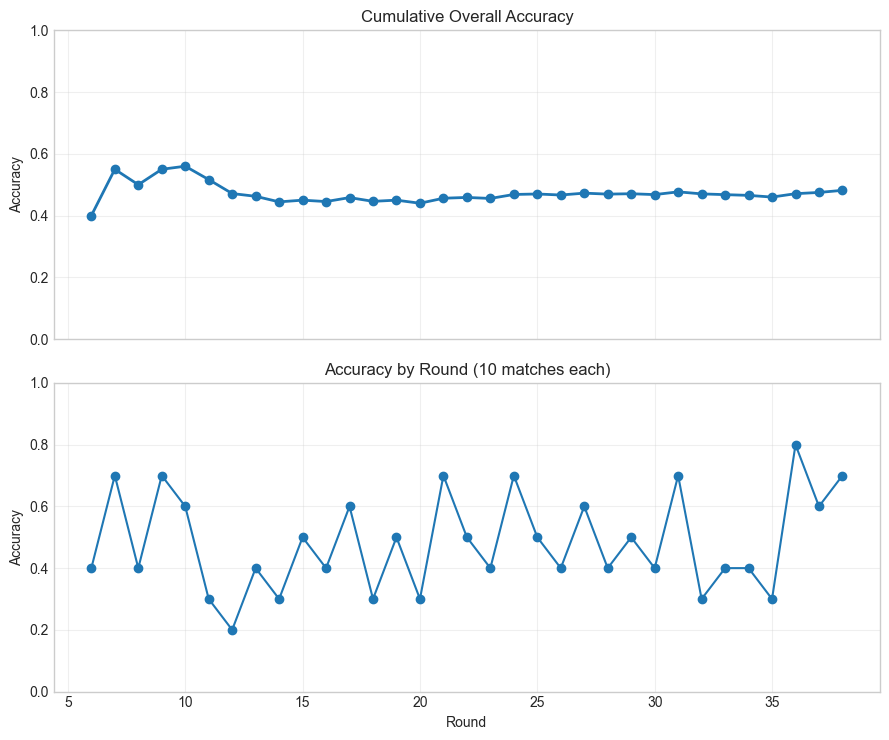

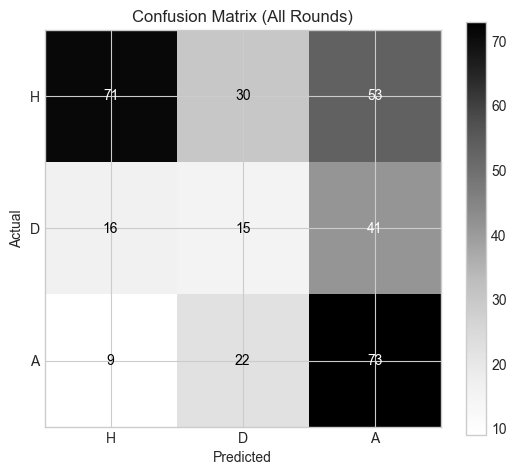

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# 7.1 Overall accuracy (text)
overall_acc = accuracy_score(actuals, preds)
print(f"Overall accuracy (rounds {WARMUP_ROUNDS + 1}–{max_round}): {overall_acc:.3f}")

# 7.2 Build results (ordered)
res_df = pd.DataFrame({'Round': rounds, 'Pred': preds, 'Actual': actuals}).sort_values('Round')

# 7.3 Per-round accuracy + cumulative overall accuracy (weighted by matches)
acc_by_round = (
    res_df.groupby('Round')
          .apply(lambda g: accuracy_score(g['Actual'], g['Pred']))
          .reset_index(name='Accuracy')
          .sort_values('Round')
)
res_df['Correct'] = (res_df['Pred'] == res_df['Actual']).astype(int)
agg = res_df.groupby('Round').agg(CorrectCount=('Correct','sum'), N=('Correct','size')).reset_index().sort_values('Round')
agg['CumCorrect'] = agg['CorrectCount'].cumsum()
agg['CumTotal']   = agg['N'].cumsum()
agg['CumAcc']     = agg['CumCorrect'] / agg['CumTotal']

# 7.4 Plots: cumulative (top) + per-round (bottom)
fig, axes = plt.subplots(2, 1, figsize=(9, 7.5), sharex=True)

axes[0].plot(agg['Round'], agg['CumAcc'], marker='o', linewidth=2)
axes[0].set_title('Cumulative Overall Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0.0, 1.0)
axes[0].grid(True, alpha=0.3)

axes[1].plot(acc_by_round['Round'], acc_by_round['Accuracy'], marker='o')
axes[1].set_title('Accuracy by Round (10 matches each)')
axes[1].set_xlabel('Round')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.0, 1.0)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7.5 Confusion matrix (H, D, A) — heatmap with counts
label_order = [1, 0, -1]  # Home, Draw, Away
label_to_str = {1:'H', 0:'D', -1:'A'}
cm = confusion_matrix(actuals, preds, labels=label_order)

plt.figure(figsize=(5.6, 4.8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (All Rounds)')
plt.colorbar()
tick_marks = np.arange(len(label_order))
plt.xticks(tick_marks, [label_to_str[x] for x in label_order])
plt.yticks(tick_marks, [label_to_str[x] for x in label_order])
plt.xlabel('Predicted'); plt.ylabel('Actual')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.tight_layout()
plt.show()


8. Gradio Interface

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np

# ----------------------------------------------------------------------------
# Precompute the training-set means of the odds-derived features:
# ----------------------------------------------------------------------------
odd_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread'
]
odd_means = df[odd_feats].mean()

# ----------------------------------------------------------------------------
# Gradio dropdown choices:
# ----------------------------------------------------------------------------
teams = sorted(df['HomeTeam'].unique())
refs  = sorted(df['Referee'].unique())
times = ['Morning','Afternoon','Evening']

# ----------------------------------------------------------------------------
# Prediction function
# ----------------------------------------------------------------------------
def predict_outcome(home_team, away_team, referee, time_of_day):
    # 1) Pull the last historical row for each entity
    home = df[df.HomeTeam == home_team].iloc[-1]
    away = df[df.AwayTeam == away_team].iloc[-1]
    ref  = df[df.Referee == referee].iloc[-1]
    
    # 2) Assemble the feature dict
    data = {}
    
    # 2a) Odds-derived features: fill with their training-set means
    for feat in odd_feats:
        data[feat] = odd_means[feat]
    
    # 2b) Rolling form & streaks
    data['HomeForm3']  = home['HomeForm3']
    data['AwayForm3']  = away['AwayForm3']
    data['HomeStreak'] = home['HomeStreak']
    data['AwayStreak'] = away['AwayStreak']
    
    # 2c) Interaction term
    data['OddsSpread']    = odd_means['OddsSpread']
    data['Spread×Form']   = data['OddsSpread'] * data['HomeForm3']
    
    # 2d) Referee bias
    data['RefBias'] = ref['RefBias']
    
    # 2e) Head-to-head last
    pair = ((df.HomeTeam==home_team)&(df.AwayTeam==away_team)) | \
           ((df.HomeTeam==away_team)&(df.AwayTeam==home_team))
    data['H2H_Last'] = df[pair].iloc[-1]['H2H_Last']
    
    # 2f) Previous round positions
    data['HomePosPrev'] = home['HomePosPrev']
    data['AwayPosPrev'] = away['AwayPosPrev']
    
    # 2g) Rolling match-stats (shots, fouls, cards)
    for s in home_stats:
        data[f'Home_{s}_3'] = home[f'Home_{s}_3']
    for s in away_stats:
        data[f'Away_{s}_3'] = away[f'Away_{s}_3']
    
    # 2h) Categorical features
    data['HomeTeam']  = home_team
    data['AwayTeam']  = away_team
    data['Referee']   = referee
    data['TimeOfDay'] = time_of_day
    
    # 3) Build DataFrame and predict
    Xnew  = pd.DataFrame([data])
    probs = final_model.predict_proba(Xnew)[0]
    classes = list(final_model.classes_)  # e.g. [-1,0,1]
    
    # Return probabilities as percentages
    return (
        float(probs[classes.index(1)] * 100),
        float(probs[classes.index(0)] * 100),
        float(probs[classes.index(-1)] * 100)
    )

# ----------------------------------------------------------------------------
# Launch Gradio interface
# ----------------------------------------------------------------------------
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(teams, label="Home Team"),
        gr.Dropdown(teams, label="Away Team"),
        gr.Dropdown(refs,  label="Referee"),
        gr.Dropdown(times, label="Time of Day"),
    ],
    outputs=[
        gr.Number(label="Home Win %"),
        gr.Number(label="Draw %"),
        gr.Number(label="Away Win %")
    ],
    title="Premier League Outcome Predictor (RF → MLP Hybrid)",
    description=(
        "Select Home/Away teams, Referee and Time of Day. "
        "Odds-derived features are filled with their historical averages, "
        "all other features are pulled from past matches. "
        "Predictions come from a two-stage RandomForest → MLP stacked model."
    )
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7878

To create a public link, set `share=True` in `launch()`.
